In [1]:
import random
import os

import pickle 
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

# For dynamic bucketing
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset,Sampler
from torch.utils.data import DataLoader

import torchaudio
from torchaudio.transforms import Spectrogram

from IPython.display import Audio, Markdown, display

In [2]:
# Check if GPU availability and set the device
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")

# Check if the device is set correctly
print(f"Device set to: {device}")

# Set the audio backend to soundfile (Uncomment if needed)
torchaudio.set_audio_backend("soundfile")

Using GPU: NVIDIA GeForce RTX 3060
Device set to: cuda


/tmp/ipykernel_1236662/690487593.py:13: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [3]:
# I want a visual to show the effect of padding the data set to the maximum

class MaxPaddingDataset(Dataset):
    def __init__(self, dataset_dir, set_type, rate):
        self.rate = rate
        self.clean_dir = os.path.join(dataset_dir, f"clean_{set_type}_wav")
        self.noisy_dir = os.path.join(dataset_dir, f"noisy_{set_type}_wav")

        self.clean_files = sorted([os.path.join(self.clean_dir, f) for f in os.listdir(self.clean_dir)], key=lambda x: os.path.basename(x))
        self.noisy_files = sorted([os.path.join(self.noisy_dir, f) for f in os.listdir(self.noisy_dir)], key=lambda x: os.path.basename(x))

        # Precompute all original lengths
        self.original_lengths = [torchaudio.load(f)[0].shape[1] for f in self.clean_files]
        self.max_length = max(self.original_lengths)

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        clean, sr_c = torchaudio.load(self.clean_files[idx])
        noisy, sr_n = torchaudio.load(self.noisy_files[idx])

        # Convert stereo to mono
        clean = clean.mean(dim=0, keepdim=True) if clean.shape[0] > 1 else clean
        noisy = noisy.mean(dim=0, keepdim=True) if noisy.shape[0] > 1 else noisy

        # Resample if needed
        if sr_c != self.rate:
            clean = T.Resample(sr_c, self.rate)(clean)
        if sr_n != self.rate:
            noisy = T.Resample(sr_n, self.rate)(noisy)

        # Pad both to max length
        pad_len = self.max_length - clean.shape[1]
        clean_padded = F.pad(clean, (0, pad_len))
        noisy_padded = F.pad(noisy, (0, pad_len))

        return noisy_padded, clean_padded, self.original_lengths[idx], self.max_length


In [4]:
def visualize_max_padding_effect(dataset, save_path=None):
    import numpy as np
    from collections import Counter

    original_lengths = dataset.original_lengths
    max_len = dataset.max_length
    sr = dataset.rate

    paddings = [max_len - l for l in original_lengths]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # === Plot 1: Original Length Distribution ===
    axes[0].hist(original_lengths, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel("Original Length (samples)")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Original Audio Length Distribution")
    axes[0].grid(True)

    # === Plot 2: Single Horizontal Bar ===
    from collections import Counter
    most_common_length = Counter(original_lengths).most_common(1)[0][0]
    padding_needed = max_len - most_common_length

    axes[1].barh(["Most Common Length"], [most_common_length], color='skyblue', label="Original Length")
    axes[1].barh(["Most Common Length"], [padding_needed], left=[most_common_length], color='salmon', label="Padding")

    axes[1].set_xlim(0, max_len + sr // 10)
    axes[1].set_xlabel("Samples")
    axes[1].set_title("Padding Visualization for Most Common Length")
    axes[1].legend(loc="lower right")
    axes[1].grid(False)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved to {save_path}")
    else:
        plt.show()


✅ Saved to max_padding_effect.png


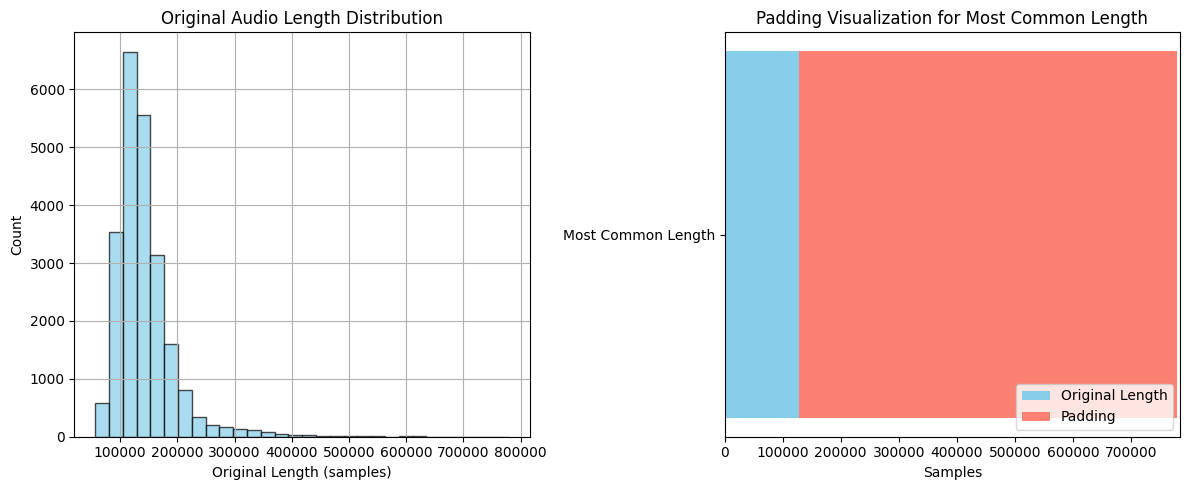

In [5]:
# === Usage ===
dataset_dir = "ED-Noisy-Speech-Datashare"
sr = 48000
n_fft = 1024
hop_length = 256

# Use dynamic bucketing
num_buckets = 5

# Initialize the dataset
train_dataset = MaxPaddingDataset(dataset_dir, "trainset_56spk", sr)

# Initialize the DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# Visualize the effect of padding
visualize_max_padding_effect(train_dataset, save_path="max_padding_effect.png")
